#### Importing packages

In [1]:
# Importing the scripts
from webdesign.polls.scripts import preprocess
from webdesign.polls.scripts import categorize
from webdesign.polls.scripts import analyze
from webdesign.polls.scripts import visualize

# Importing other packages
import pandas as pd

#### Importing CSV

In [2]:
input_ts = pd.read_csv('data/va_covid_occupancy.csv',parse_dates=['date'])

#### Preprocess

In [3]:
pp_ts = preprocess.fill_dates(input_ts,'D')  ### fill dates

fill_method = 'linear'
pp_ts = preprocess.fill_values(pp_ts,fill_method)

pp_ts = preprocess.smoothing(pp_ts,7)

#### Categorize

In [4]:
cat_method = 'T-rate'
num_bins = 5
win_size = 7

if cat_method[0] == 'L':
    cat_ts, bin_bounds = categorize.level_categorize(pp_ts,cat_method,num_bins)
else:
    trend_ts, (cat_ts, bin_bounds) = categorize.trend_categorize(pp_ts,cat_method,win_size,num_bins)



#### Analyze

In [5]:
analyze.cat_counts(cat_ts)

R3    879
R2    107
R4     87
R5     13
R1     10
Name: value, dtype: int64

#### Visualize

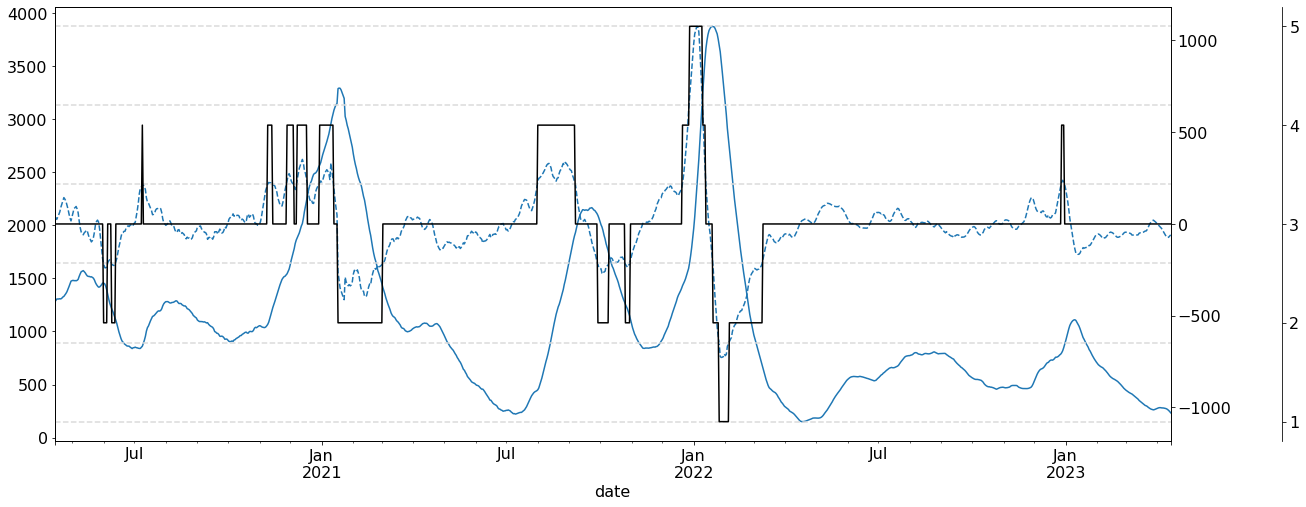

In [6]:
if cat_method[0] == 'L':
    visualize.dualPlot(pp_ts,cat_ts,bin_bounds)
else:
    visualize.triplePlot(pp_ts,trend_ts,cat_ts,bin_bounds)